# Modeling

In [501]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, explained_variance_score, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
np.random.seed(42)

In [26]:
df = pd.read_csv('./data/clean.csv', index_col='Unnamed: 0')

In [27]:
df.head()

,author,anxiety,title,selftext,created_utc,retrieved_on,url,pinned,media_only,adhd
0,ZorroNegro,1.0,"Please, I need help",My friend asked me to be his best man for his ...,1554340190,1554340191,https://www.reddit.com/r/Anxiety/comments/b96c...,False,False,0.0
1,PupperinoSuprimo,1.0,"If you'll never really know, let that damn tho...","Lately, this has become a sort of mantra Ive s...",1554338785,1554338785,https://www.reddit.com/r/Anxiety/comments/b964...,False,False,0.0
2,moake740,1.0,Feeling like such a failure,"I suck, I haven’t been taking my meds a prescr...",1554338572,1554338573,https://www.reddit.com/r/Anxiety/comments/b963...,False,False,0.0
3,ketchuptiles,1.0,Rolling anxiety attacks?,"Hey everyone, I could really use your collect...",1554338312,1554338313,https://www.reddit.com/r/Anxiety/comments/b961...,False,False,0.0
5,SageLukahn,1.0,Why I don't try new things.,I am on a diet (keto). It is not a particularl...,1554337837,1554337838,https://www.reddit.com/r/Anxiety/comments/b95y...,False,False,0.0


Using the custom stopwords from the EDA, and adding a few more

In [320]:
custom_words = frozenset(['just', 'like', 'im', 'ive', 've', 'dont', 'don', 'https', 'http', 'www', 'com'])

In [321]:
stopwords = ENGLISH_STOP_WORDS.union(custom_words)

Instead of count vectorization, this time I'll be using term frequency-inverse document frequency (TF-IDF) vectorization. Instead of simply counting the frequencies of our words, TF-IDF tries to distinguish their importance by assigning weights proportional to the number of times a word appear in a specific post, offset by the  number of posts that use that word. Again, I'll be setting a minimum document frequency of 5 (i.e. words must be in at least 5 posts to be included in our model). Setting the max_df to 1.0 means that no words will be left out because they are too common (but hopefully our TF-IDF algorithm will weight them so lightly that they won't matter). 

In [322]:
tfidf = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=1.0)

In [323]:
term_mat = tfidf.fit_transform(df['selftext'])

In [324]:
len(tfidf.get_feature_names())

4642

We see here that we get 4642 words after using the TF-IDF Vectorizer, just like with the CountVectorizer

In [325]:
term_df = pd.SparseDataFrame(term_mat, columns=tfidf.get_feature_names())

In [326]:
from sys import getsizeof

In [327]:
getsizeof(term_df)

2768912

Here I'm just testing out the difference between storing the data as a dense matrix or a sparse matrix. It absolute terms, it is insignificant here, but it is a good thing to keep going forward, if I choose to scale my data and look at a lot more posts. 

In [328]:
dense_term_df = pd.DataFrame(term_mat.todense(), columns=tfidf.get_feature_names())

In [329]:
getsizeof(dense_term_df)

133058392

In [330]:
(getsizeof(dense_term_df) - getsizeof(term_df)) / getsizeof(dense_term_df)

0.9791902490449457

Keeping the data sparse reduces its size by 98%!

In [331]:
term_df.fillna(0, inplace=True)
getsizeof(term_df)

2768912

---

Taking the sparse TF-IDF created dataframe and using singular value decomposition (SVD) on it to perform latent semantic analysis (LSA). If you're not familiar with SVD, it is similar to principal components analysis (PCA), but does not center the data. In Python, computing the SVD is similar to any other sklearn preprocessing method, where we fit and transform our data. Normally, we would want to split our data into training and testing sets before running our decomposition. However, I'm not worried too about the variance of our validation data impacting our components. As we'll see later, the results do not differ much between these models and those run without SVD. 

In [332]:
SVD = TruncatedSVD(n_components=300)
svd_matrix = SVD.fit_transform(term_df)
svd_matrix.shape

(3583, 300)

Much like tuning hyperparameters, I experimented with many numbers of components. As the number increased, I saw diminishing marginal returns on the variance explained and decided to stick with 300 based on a brief literature review. 

In [333]:
SVD.components_.shape

(300, 4642)

Text(0.5, 1.0, 'Explained variance by component')

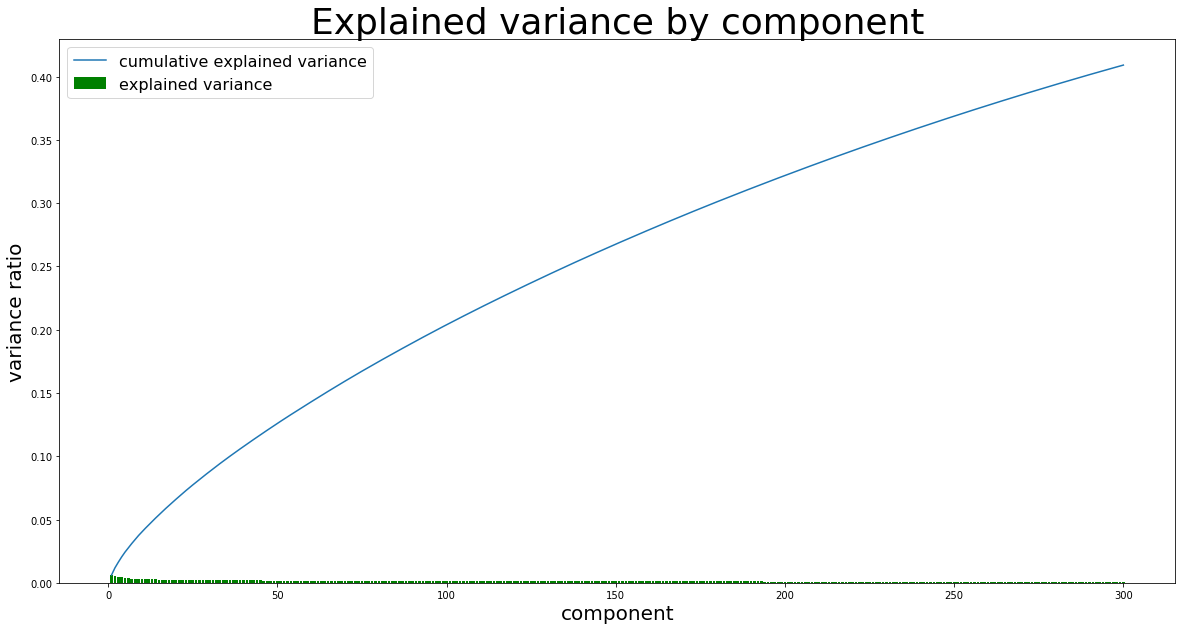

In [334]:
fig = plt.figure(figsize=(20,10))
plt.bar(np.array(range(300))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='explained variance')
plt.plot(np.array(range(300))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='cumulative explained variance')
plt.legend(fontsize=16)
plt.xlabel('component', fontsize=20)
plt.ylabel('variance ratio', fontsize=20)
plt.title('Explained variance by component', fontsize=36)

As we can see, the ratio of each component's variance explained is miniscule, but cumulatively we have nearly 40% of the variation explained by our components. Below I take a peek at the first couple components to see if any themes emerge. 

In [335]:
component_names = ["component_"+str(i+1) for i in range(300)]
svd_df = pd.DataFrame(svd_matrix,
                      columns=component_names)

Here I'm creating a dataframe from our components.

In [336]:
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_291,component_292,component_293,component_294,component_295,component_296,component_297,component_298,component_299,component_300
0,0.161309,-0.072316,-0.049109,-0.008680,-0.095950,-0.080823,0.001907,0.058468,0.090225,-0.015571,...,-0.000268,-0.052091,0.019748,0.007427,-0.029368,0.036053,-0.000146,-0.006426,0.031000,0.028253
1,0.167980,-0.031128,-0.014054,-0.023008,-0.012362,-0.033852,0.044454,-0.066216,-0.080435,-0.011370,...,0.031944,0.030857,-0.001889,0.016046,0.062433,-0.020149,0.043142,0.027204,-0.015150,0.052744
2,0.139702,0.094345,-0.043858,-0.020355,0.025721,0.078185,0.048642,-0.015230,0.017249,0.036598,...,-0.059610,-0.006138,0.029204,0.023359,-0.019263,0.002235,0.006782,-0.034191,0.017416,0.010450
3,0.209874,0.012623,0.110905,0.081225,-0.119232,0.011293,0.121104,-0.096597,-0.001491,0.057759,...,0.063594,-0.047913,0.004686,0.022158,0.007044,0.001596,0.042693,-0.019942,0.027499,-0.004188
4,0.178710,-0.026995,-0.049401,0.015506,-0.013344,-0.048222,-0.015269,-0.018799,-0.055171,-0.035643,...,-0.007101,-0.022279,-0.051901,0.038046,-0.022117,-0.039954,-0.015497,0.017747,-0.007365,-0.016388


I want to sort by the first few components, so I need to take their loadings and calculate new columns with their magnitudes (i.e. absolute values)

In [337]:
loadings = pd.DataFrame(SVD.components_,
                        index=component_names,
                        columns=term_df.columns).T

In [338]:
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)
loadings['abs_component_3'] = np.abs(loadings.component_3)

In [339]:
loadings.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_294,component_295,component_296,component_297,component_298,component_299,component_300,abs_component_1,abs_component_2,abs_component_3
00,0.003548,0.001539,-0.006049,0.003969,-0.002424,-0.007892,-0.009285,-0.001790,0.005711,-0.002692,...,0.011289,0.031096,0.003125,-0.011981,0.020452,0.017061,-0.019187,0.003548,0.001539,0.006049
000,0.002185,0.000680,-0.002684,0.003781,0.000525,0.004947,0.002315,0.004118,0.000435,-0.004923,...,0.011169,0.001864,0.001952,0.001123,-0.005362,0.003021,-0.003780,0.002185,0.000680,0.002684
03,0.001055,-0.000737,-0.002974,-0.000331,-0.002323,0.000653,0.000809,-0.007532,-0.001955,-0.005950,...,-0.060555,0.061548,0.026139,-0.028302,-0.036431,0.011081,0.006493,0.001055,0.000737,0.002974
10,0.027650,0.042024,-0.004099,0.018713,-0.005402,-0.038691,0.002847,-0.009192,0.001967,-0.014468,...,0.050183,0.045662,0.036507,-0.059147,-0.053731,-0.026553,0.028855,0.027650,0.042024,0.004099
100,0.013208,0.003061,-0.000189,0.010879,-0.013777,0.000311,-0.011827,0.000420,-0.006169,0.005201,...,-0.010058,0.014815,0.041193,0.006255,-0.028909,-0.018893,-0.015947,0.013208,0.003061,0.000189


In [340]:
loadings.sort_values('abs_component_1',ascending=False).head(20)[['component_1']]

,component_1
feel,0.217621
know,0.174151
time,0.167186
really,0.166781
want,0.141762
work,0.133374
people,0.128194
things,0.125025
day,0.122996
going,0.120098


Component one seems to be regarding the time management issue that I previously touched upon. People with ADHD knowing that there is work to do, and really want to do it, but struggle with managing their time and feel bad for not being able to handle the little, everyday things that other people take for granted. 

In [341]:
loadings.sort_values('abs_component_2',ascending=False).head(20)[['component_2']]

,component_2
adderall,0.239768
medication,0.225831
taking,0.218932
meds,0.218444
vyvanse,0.199065
people,-0.197572
effects,0.157622
know,-0.150418
want,-0.148332
day,0.147275


Component 2 seems to be regarding various medication and their prescription/dosage. Interestingly, we can see negative loadings for people, friends, know, think, want, talk, and anxious, because they don't relate to the medication. Below I plot these two components to see if any discernible separation exists.

In [342]:
df2 = df.reset_index(drop=True)

In [343]:
target=df2['adhd']

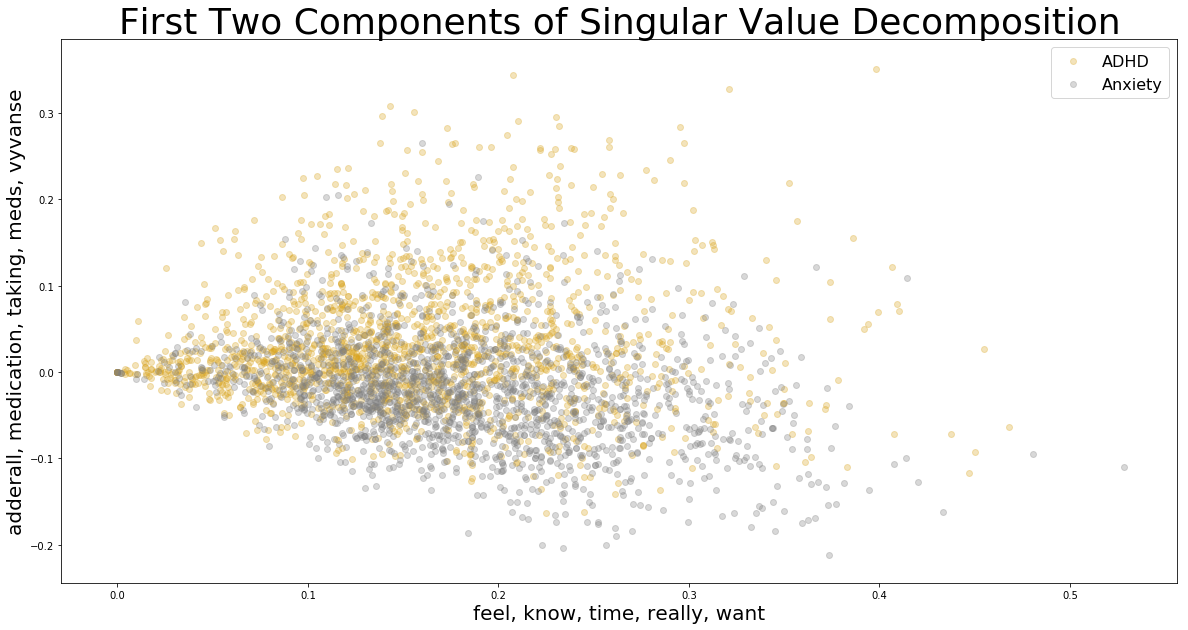

In [540]:
plt.figure(figsize=(20,10))
plt.scatter(svd_df.component_1[target==1], svd_df.component_2[target==1], c='goldenrod', alpha=.3)
plt.scatter(svd_df.component_1[target==0], svd_df.component_2[target==0], c='grey', alpha=.3)
plt.xlabel(f"{', '.join(loadings.sort_values('abs_component_1',ascending=False).head(5)[['component_1']].index)}",
          fontsize=20)
plt.ylabel(f"{', '.join(loadings.sort_values('abs_component_2',ascending=False).head(5)[['component_2']].index)}",
          fontsize=20)
plt.title('First Two Components of Singular Value Decomposition', fontsize=36)
plt.legend(['ADHD', 'Anxiety'], fontsize=16)
plt.savefig('./assets/components_12.png')

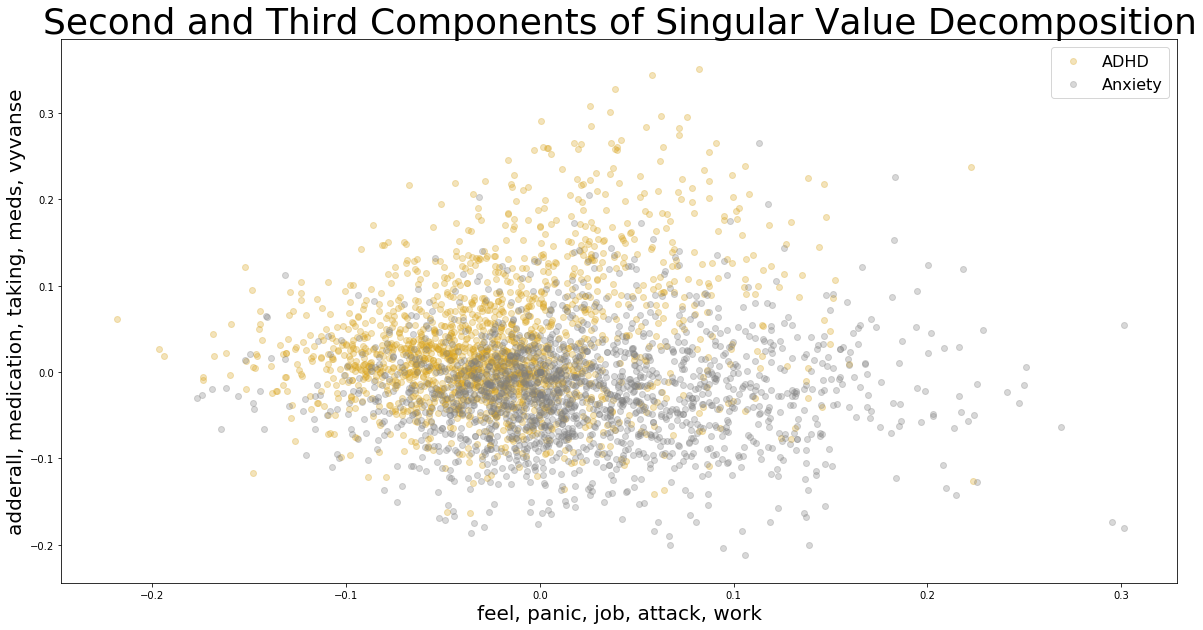

In [541]:
plt.figure(figsize=(20,10))
plt.scatter(svd_df.component_3[target==1], svd_df.component_2[target==1], c='goldenrod', alpha=.3)
plt.scatter(svd_df.component_3[target==0], svd_df.component_2[target==0], c='grey', alpha=.3)
plt.xlabel(f"{', '.join(loadings.sort_values('abs_component_3',ascending=False).head(5)[['component_3']].index)}",
          fontsize=20)
plt.ylabel(f"{', '.join(loadings.sort_values('abs_component_2',ascending=False).head(5)[['component_2']].index)}",
          fontsize=20)
plt.title('Second and Third Components of Singular Value Decomposition', fontsize=36)
plt.legend(['ADHD', 'Anxiety'], fontsize=16)
plt.savefig('./assets/components_23.png')

Here we can see that there is not very good separation of our subreddits in the first 2 components. For the second and third compondents there seems to be a bit more separation, but there is still a lot of overlap, which is to be expected. Thus, I'm going to explore some of the most similar posts, using a cosine similarity matrix.

In [346]:
cos_sim_mat = cosine_similarity(svd_matrix, svd_matrix)
cos_sim_mat.shape

(3583, 3583)

In [347]:
np.argsort(cos_sim_mat[1])[:-11:-1]

array([   1, 1013, 1342,  945,  523,  234,  388,  864, 3572,  262])

In [348]:
np.sort(cos_sim_mat[1])[:-11:-1]

array([1.        , 0.42566652, 0.36494152, 0.32828105, 0.31980057,
       0.31705932, 0.31683094, 0.31550904, 0.31502747, 0.31023004])

Plugging in these indices back into the original dataframe to see which posts are most similar.

In [349]:
df2.loc[np.argsort(cos_sim_mat[50])[:-11:-1], :]['adhd']

50      0.0
1387    0.0
1741    0.0
1908    1.0
57      0.0
2855    1.0
316     0.0
1400    0.0
2865    1.0
2716    1.0
Name: adhd, dtype: float64

We can see that only 3 posts of the top 10 most similar posts are from the ADHD subreddit

In [350]:
df2.loc[np.argsort(cos_sim_mat[50])[:-11:-1], :]['selftext']

50      every now and then i get this weird cheek pull...
1387    Hello, Ive recently been diagnosed with GAD. S...
1741    So I bummed my head real hard and now Im scare...
1908                              But maybe I’m just lazy
57      Any progress Id made feels wiped out. All thos...
2855    But I HAVE TO!!  But I dont WANT to!!  But I H...
316     I try my best to be nice I try my best to appr...
1400    Hey Everyone,   I grew up im a country where w...
2865    Ive noticed that whenever I get really deeply ...
2716    He also responds to every little sound and dis...
Name: selftext, dtype: object

If we didn't know which posts were from which subreddit, we might well have a difficult time classifying these posts ourselves. Of course, the word diagnosis can apply to both. In the future I would want to dive deeper into specific conditions of anxiety social anxiety or Generalized Anxiety Disorder.

---

Now let's see how this performs with a simple Logistic Regression model

In [351]:
X_train, X_test, y_train, y_test = train_test_split(svd_df, target, stratify=target, random_state=42)

In [352]:
lr = LogisticRegression()

In [353]:
lr.fit(X_train, y_train)

/Users/Hovanes/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [354]:
lr.score(X_train, y_train)

0.8868626721250465

In [355]:
lr.score(X_test, y_test)

0.84375

Surprisingly, logistic regression performed well. On the training set, the accuracy rate was 89% and on the test set it was 84%. Now let's compare it with a Random Forests Classifier. If you're unfamiliar with Random Forests, the name comes from its relation to Decision Trees, which is essentially a classifier based on splitting up the data using many if-statements. Random Forests classification uses many (i.e. bagged) decision trees, bootstraps them (i.e. sampling with replacement), and modifies the tree learning algorithm so that at each split in the learning process, a random subset of features (in this case words) is used. 

In [545]:
params = {'min_samples_split': [2, 4, 8, 15],
          'min_samples_leaf': [1, 3, 5, 10]}

I set the hyperparameters above for the minimum data points required for a decision tree split and the creation of a new leaf. I tried out many combinations of values, but the differences in the scores was no more than 5%.

In [546]:
gs = GridSearchCV(RandomForestClassifier(n_estimators=100), 
                  param_grid=params, return_train_score=True, cv=5, n_jobs=-1)

In [547]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_split': [2, 4, 8, 15], 'min_samples_leaf': [1, 3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [548]:
gs.score(X_train, y_train)

0.9892072943803498

In [549]:
gs.score(X_test, y_test)

0.8125

As expected, our Random Forest model overfit on the training set, getting an accuracy of over 99%, but did slightly worse on the test set than the logistic regression model, getting only 81%.

In [550]:
gs.best_params_

{'min_samples_leaf': 10, 'min_samples_split': 15}

The above accuracy numbers were generated from the GridSearch algorithm choosing the best combination of 3 minimum samples per leaf and 15 minimum samples per split as the optimal hyperparameters.

In [551]:
gs.best_estimator_.feature_importances_

array([0.01653048, 0.09240632, 0.07416642, 0.03710363, 0.02548169,
       0.02389811, 0.00438316, 0.00929932, 0.00229621, 0.0066409 ,
       0.00282662, 0.00440483, 0.02691093, 0.00795803, 0.0028538 ,
       0.00395039, 0.00319161, 0.00223911, 0.00639924, 0.00273734,
       0.00372453, 0.00534471, 0.00396168, 0.00705996, 0.00344878,
       0.00577928, 0.00415161, 0.00485941, 0.00196484, 0.00381455,
       0.00243951, 0.00301855, 0.00227764, 0.003405  , 0.00422048,
       0.00228789, 0.00426724, 0.00241387, 0.00331161, 0.00186715,
       0.00293559, 0.00330289, 0.00383163, 0.00475989, 0.00223332,
       0.00513203, 0.0023925 , 0.00647606, 0.00492094, 0.0028676 ,
       0.00276762, 0.00168738, 0.00304301, 0.00289015, 0.00249843,
       0.00353141, 0.0026044 , 0.00207102, 0.00239822, 0.00407761,
       0.00239083, 0.00138091, 0.0036481 , 0.00249449, 0.00395456,
       0.00376097, 0.00190755, 0.00264373, 0.00229329, 0.00262864,
       0.00170517, 0.00154823, 0.00244314, 0.00261253, 0.00187

Here I'm grabbing the most important components from the best estimator in the model above and graphing it to visualize the amount of variance explained by each component. 

In [552]:
feat_importance = pd.DataFrame(gs.best_estimator_.feature_importances_, svd_df.columns, columns=['importance'])

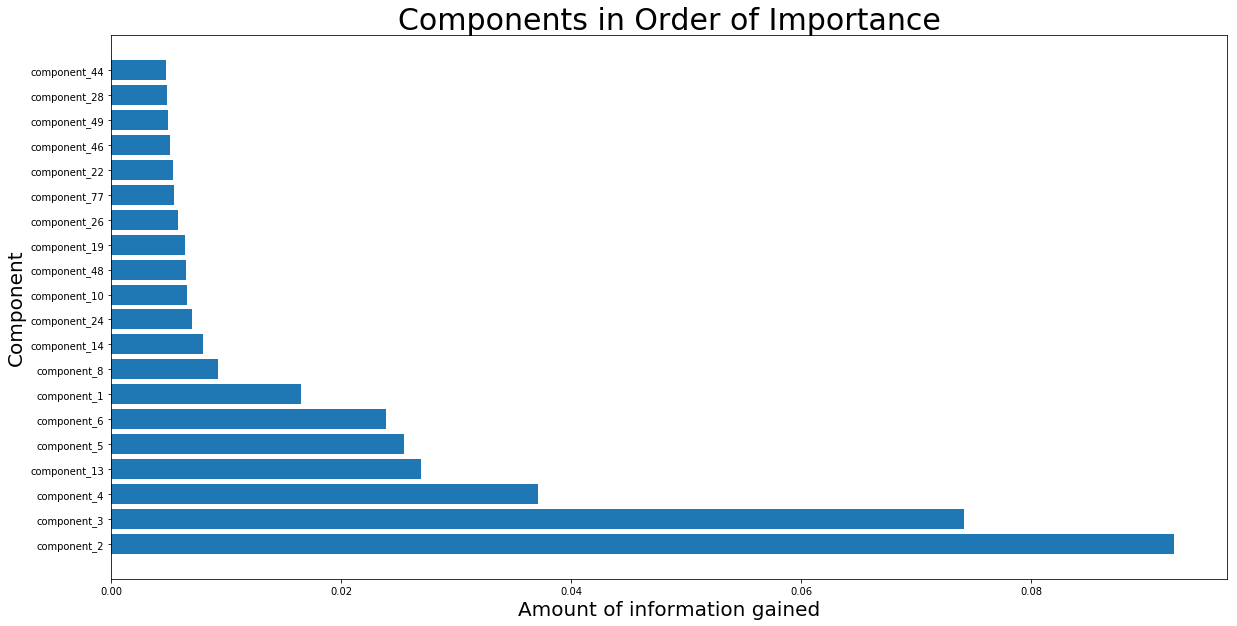

In [553]:
plt.figure(figsize=(20,10))
temp = feat_importance.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'])
plt.title("Components in Order of Importance", fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Component', fontsize=20)
plt.savefig('./assets/impcomp.png')

Interestingly, component 2, which I previously described as the medication-related component provides the most information gain. It is followed by the third component, which seemed to be regarding job-related panic attacks and general anxiety towards work. Regardless, because these components are not as intuitive to look at as the words themselves, so I will rerun the models without using singular value decomposition to provide this same graph for the most important words.

In [444]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(term_df, target, stratify=target, random_state=42)

In [515]:
lr2 = LogisticRegression()

In [516]:
lr2.fit(X_train2, y_train2)

/Users/Hovanes/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [517]:
lr2.score(X_train2, y_train2)

0.9378489021213249

In [518]:
lr2.score(X_test2, y_test2)

0.8504464285714286

This time, using only TF-IDF rather than SVD, logistic regression performed substantially better on the training set and slightly better on the test set, so I will use this as my final production model.

In [519]:
lr2_preds = lr.predict(X_test2)

Here I'm generating the confusion matrix, to see the breakdown of the sensitivity and specificity of the model

In [459]:
confusion_matrix(y_test2, lr2_preds)

array([[359,  82],
       [ 52, 403]])

In [461]:
tn, fp, fn, tp = confusion_matrix(y_test2, lr2_preds).ravel()

In [462]:
spec = tn/(tn+fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.8141


The logistic regression model's specificity (i.e. true negative rate) is 81%, meaning that of the posts that were actually from the anxiety subreddit, 81% were correctly classified. 

In [463]:
sens = tp/(tp+fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.8857


The logistic regression model's sensitivity (i.e. true positive rate) is 89%, meaning that of the posts that were actually from the ADHD subreddit, 89% were correctly classified. To better visualize this tradeoff between sensitivity and specificity, I will graph the receiver operating characteristic (ROC) curve below.

In [537]:
pred_proba = [i[1] for i in lr2.predict_proba(X_test2)]

In [538]:
pred_df = pd.DataFrame({'true_values': y_test2, 'pred_probs': pred_proba})

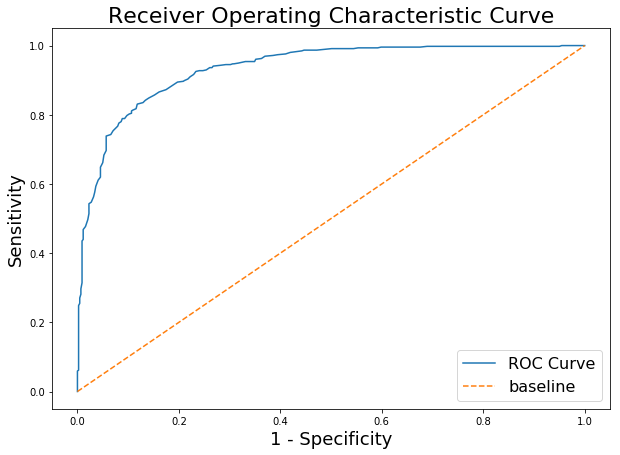

In [532]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16)

# Save the image
plt.savefig('./assets/AUC_ROC_LogReg.png');

In [539]:
roc_auc_score(pred_df.true_values, pred_df.pred_probs)

0.9330642146968678

---

In [554]:
gs = GridSearchCV(RandomForestClassifier(n_estimators=100), 
                  param_grid=params, return_train_score=True, cv=5, n_jobs=-1)

In [555]:
gs.fit(X_train2, y_train2)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_split': [2, 4, 8, 15], 'min_samples_leaf': [1, 3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [556]:
gs.score(X_train2, y_train2)

0.9981391886862672

In [557]:
gs.score(X_test2, y_test2)

0.8236607142857143

In [558]:
gs.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 15}

This time the GridSearch performed a little better on the test set, with the accuracy score going up by about 2 percentage points. 

In [559]:
rf_preds = gs.predict(X_test2)

In [560]:
confusion_matrix(y_test2, rf_preds)

array([[360,  81],
       [ 77, 378]])

In [561]:
tn2, fp2, fn2, tp2 = confusion_matrix(y_test2, rf_preds).ravel()

In [562]:
spec2 = tn2/(tn2+fp2)

print(f'Specificity: {round(spec2,4)}')

Specificity: 0.8163


The random forests model's specificity was 83%, slightly higher than the logistic regression model. 

In [500]:
sens2 = tp2/(tp2+fn2)

print(f'Sensitivity: {round(sens2,4)}')

Sensitivity: 0.8176


However, the sensitivity this time was much lower, at only 82%

In [455]:
gs.best_estimator_.feature_importances_

array([1.26235693e-05, 0.00000000e+00, 2.39344365e-04, ...,
       3.60407774e-04, 0.00000000e+00, 0.00000000e+00])

In [456]:
feat_importance = pd.DataFrame(gs.best_estimator_.feature_importances_, term_df.columns, columns=['importance'])

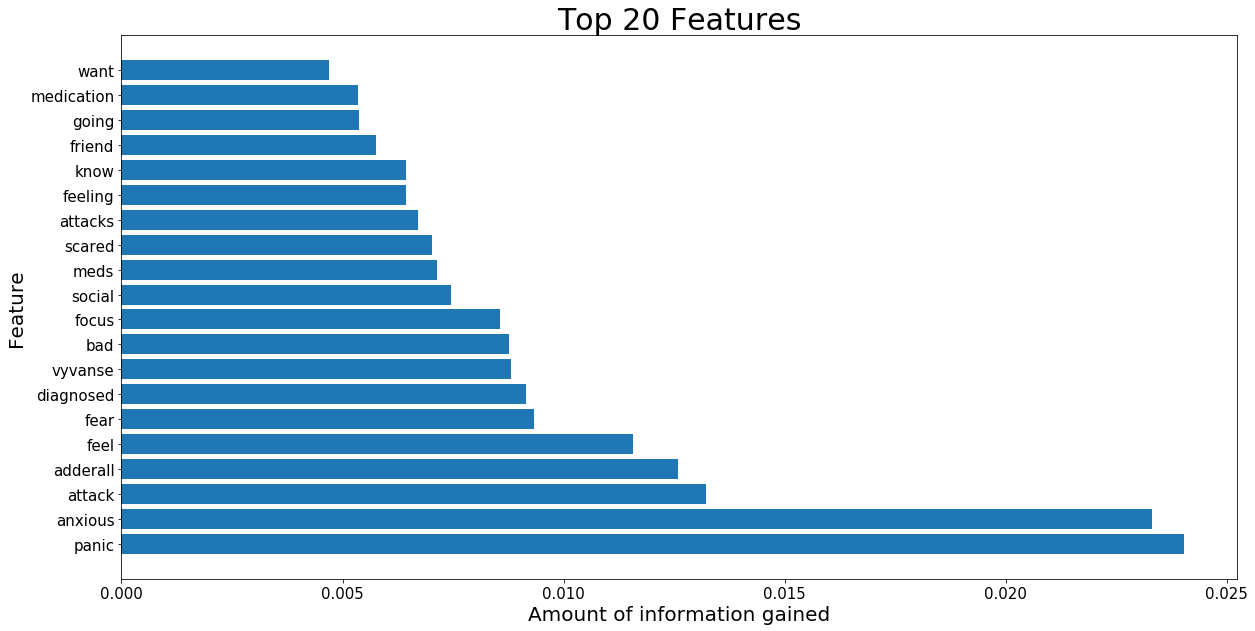

In [494]:
plt.figure(figsize=(20,10))
temp = feat_importance.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'])
plt.title("Top 20 Features", fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('./assets/top20feats.png');

Here we can see that panic, anxious, and attack are the top 3 important features in our random forests model. This is interesting, because these were not the words we focused on during the EDA process. However, the rest of the words are those we expect, such as those related to medication and emotions. 

In [533]:
pred_proba = [i[1] for i in gs.predict_proba(X_test2)]

In [534]:
pred_df = pd.DataFrame({'true_values': y_test2, 'pred_probs': pred_proba})

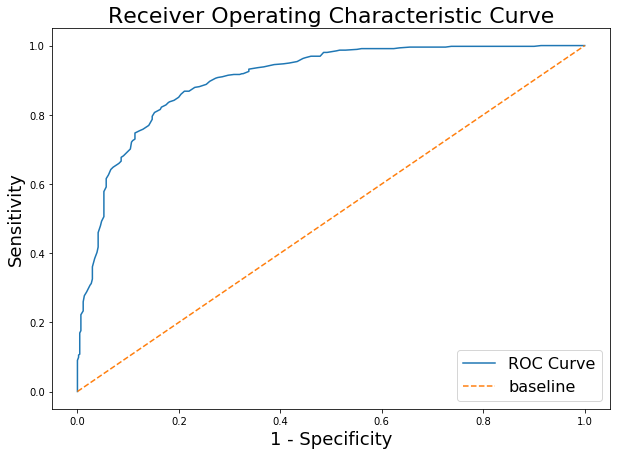

In [535]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16)

# Save the image
plt.savefig('./assets/AUC_ROC_RF.png');

In [536]:
roc_auc_score(pred_df.true_values, pred_df.pred_probs)

0.9034013605442177